In [1]:
import multiprocessing
multiprocessing.set_start_method('spawn')
multiprocessing.cpu_count()

4

## Importing necessary libraries

In [9]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [3]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter("runs/malayalam handwriting classification model - 3")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Checking the datsaset

In [11]:
# Path to a sample image
sample_img_path = "aksharam_data\അ\\3.png"

# Open the image
img = Image.open(sample_img_path)
print(f"Image mode: {img.mode}")  # Should be "RGB" or "RGBA
print(f"Image size: {img.size}")

# Convert to NumPy array and inspect pixel values
img_array = np.array(img)
print(f"Pixel range: {img_array.min()} to {img_array.max()}")


Image mode: RGB
Image size: (300, 300)
Pixel range: 0 to 255


In [12]:
# Load a single image from your dataset
image_path = "aksharam_data\ഛ\\2.png"  # Adjust this path based on your dataset
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Display the pixel values of the image
print(f"Min pixel value: {image_np.min()}")
print(f"Max pixel value: {image_np.max()}")
print(f"Mean pixel value: {image_np.mean()}")


Min pixel value: 0
Max pixel value: 255
Mean pixel value: 233.46844444444446


### Checking how many images are present per letter

In [20]:
def count_images_in_folders(base_dir):
    label_counts = {}

    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)

        if os.path.isdir(label_path):  # Ensure it's a folder
            num_images = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
            label_counts[label] = num_images

    return label_counts

# Set the base directory
base_directory = "aksharam_data"

# Get image counts per label
image_counts = count_images_in_folders(base_directory)

# Print results
for label, count in image_counts.items():
    print(f"Label '{label}' has {count} images.")

# Total images across all folders
print(f"\nTotal images: {sum(image_counts.values())}")


Label 'അ' has 800 images.
Label 'ആ' has 769 images.
Label 'ഇ' has 851 images.
Label 'ഉ' has 845 images.
Label 'ഋ' has 600 images.
Label 'എ' has 823 images.
Label 'ഏ' has 777 images.
Label 'ഒ' has 823 images.
Label 'ക' has 738 images.
Label 'ഖ' has 721 images.
Label 'ഗ' has 734 images.
Label 'ഘ' has 709 images.
Label 'ങ' has 656 images.
Label 'ച' has 698 images.
Label 'ഛ' has 715 images.
Label 'ജ' has 739 images.
Label 'ഝ' has 696 images.
Label 'ഞ' has 717 images.
Label 'ട' has 729 images.
Label 'ഠ' has 681 images.
Label 'ഡ' has 691 images.
Label 'ഢ' has 710 images.
Label 'ണ' has 730 images.
Label 'ത' has 724 images.
Label 'ഥ' has 486 images.
Label 'ദ' has 461 images.
Label 'ധ' has 704 images.
Label 'ന' has 708 images.
Label 'പ' has 676 images.
Label 'ഫ' has 714 images.
Label 'ബ' has 712 images.
Label 'ഭ' has 691 images.
Label 'മ' has 732 images.
Label 'യ' has 716 images.
Label 'ര' has 703 images.
Label 'റ' has 649 images.
Label 'ല' has 721 images.
Label 'ള' has 710 images.
Label 'ഴ' ha

### Creating the Custom dataset loader

In [18]:
class MalHandwritingDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, label)

### The final transforms
#### Loading the dataset and applying transforms

Note that transforms don't resize images that are already 32x32 dimensions, so the images from the csv file go through untouched

In [21]:
root_dir = "aksharam_data"

In [22]:
def load_data(data_augmentation=False):
    
    transform_original = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    
    transform_augmented = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(
        brightness=0.5,  # Randomly change brightness
        contrast=0.5,   # Randomly change contrast
        saturation=0.5, # Randomly change saturation
        hue=0.1         # Randomly change hue
    ),
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    
    if data_augmentation:
        original_dataset = MalHandwritingDataset(
                                csv_file="labels.csv",
                                root_dir=root_dir,
                                transform=transform_original)
        
        augmented_dataset = MalHandwritingDataset(
                                csv_file="labels.csv",
                                root_dir=root_dir,
                                transform=transform_augmented)
        
        dataset = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset])
    else:
        dataset = MalHandwritingDataset(
                            csv_file="labels.csv",
                            root_dir=root_dir,
                            transform=transform_original)
        
    # Split dataset into training and testing
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

    

In [23]:
train_loader, test_loader = load_data(data_augmentation=True)

In [ ]:
# Check the first batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch size: {images.shape}")  # e.g., torch.Size([32, 3, 32, 32])
print(f"Labels: {labels}")
print(len(labels))


Batch size: torch.Size([32, 3, 32, 32])
Labels: tensor([ 6, 10, 17,  9,  1, 38, 38, 28, 48, 12,  7, 18,  5,  6, 42,  4, 25, 13,
        31, 39, 16, 20, 32, 12, 46,  0, 21, 43, 28,  2, 27, 29])
32


#### displaying pixel values

In [25]:
# Check the min and max pixel values
print(f'Min pixel value: {images[0][0].min().item()}')
print(f'Max pixel value: {images[0][0].max().item()}')
print(f"Mean Pixel Value: {images[0][0].mean().item()}")

Min pixel value: 0.0
Max pixel value: 1.0
Mean Pixel Value: 0.8818359375


#### Visualizing one batch of images

(-0.5, 273.5, 137.5, -0.5)

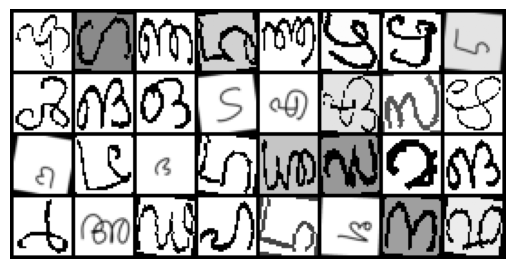

In [26]:
# Create a grid of images
img_grid = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row

# Convert the grid to a NumPy array and transpose the dimensions
np_grid = img_grid.numpy().clip(0,1)

np_grid = np_grid.transpose((1, 2, 0))

# Display the grid of images
plt.imshow(np_grid)
plt.axis('off')  # Hide the axis
# Add the grid of images to TensorBoard
# tb_writer.add_image("MalHandwriting", img_grid)
# # Close the writer
# tb_writer.close()


In [28]:
num_classes = len(os.listdir("aksharam_data"))
print(num_classes)

49


## Model Architecture

In [29]:
# Hyper-parameters
num_epochs = 500
batch_size = 32
# 6000 images in dataset, 80% for training -> 4800 images so 4800/32 = 150 iterations per epoch
learning_rate = 0.0001

In [30]:
# implement the CNN

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.AvgPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 16 * 5 * 5 is the size of the input to the fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        
        # first conv2d layer
        x = self.pool(F.relu(self.conv1(x)))

        # second conv2d layer
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten the tensor
        x = x.view(-1, 16 * 5 * 5)
        
        
        # first fully connected layer
        x = F.relu(self.fc1(x))
        
        
        # second fully connected layer  
        x = F.relu(self.fc2(x))
        
        
        # third fully connected layer
        x = self.fc3(x)
        # last is softmax layer but that is done by optimizer
        
        return x
        

In [31]:
model = ConvNet()
# Move the model to the GPU
model = model.to(device)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
tb_writer.add_graph(model, images)
tb_writer.close()

In [33]:
n_total_steps = len(train_loader)
best_loss = np.inf

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [32,3,64,64] = 32,3,1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        
        images = images.to(device)
        labels = labels.to(device)
        
        
        # forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
        
        # # Calculate accuracy
        # _, predicted = torch.max(output.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        
        # Log the loss to TensorBoard
        #tb_writer.add_scalar('Training Loss', loss.item(), epoch * n_total_steps + i)
    
        if i == n_total_steps//2:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}')
            # Save the model if the current val_loss is the lowest
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'mal_model.pth')
        
    # Calculate and log average loss and accuracy for the epoch
    epoch_loss = running_loss / n_total_steps
    #epoch_accuracy = 100 * correct / total
    #tb_writer.add_scalar('Epoch Loss', epoch_loss, epoch)
    #tb_writer.add_scalar('Epoch Accuracy', epoch_accuracy, epoch)
            
print('Finished Training')
#tb_writer.close()

KeyboardInterrupt: 

In [38]:
classes = [i for i in os.listdir("rgb_data")]
print(classes)

['അ', 'ആ', 'ഇ', 'ഉ', 'എ', 'ഏ', 'ഒ', 'ക', 'ഖ', 'ഗ', 'ഘ', 'ങ', 'ച', 'ഛ', 'ജ', 'ഝ', 'ഞ', 'ട', 'ഠ', 'ഡ', 'ഢ', 'ണ', 'ത', 'ഥ', 'ദ', 'ധ', 'ന', 'പ', 'ഫ', 'ബ', 'ഭ', 'മ', 'യ', 'ര', 'റ', 'ല', 'ള', 'ഴ', 'വ', 'ശ', 'ഷ', 'സ', 'ഹ']


In [ ]:
with torch.no_grad():
    n_samples = 0
    n_correct = 0
    n_class_correct = [0 for i in range(48)]  # 48 classes
    n_class_samples = [0 for i in range(48)]  # 48 classes

    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.2f} %')
    tb_writer.add_scalar('Accuracy/Overall', acc)

    for i in range(48):  # Iterate over the range of the number of classes
        if n_class_samples[i] > 0:
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {class_acc:.2f} %')
            tb_writer.add_scalar(f'Accuracy/{classes[i]}', class_acc)
        else:
            print(f'Accuracy of {classes[i]}: N/A (no samples)')

tb_writer.close()

### Testing one one new prediction

In [42]:
import pandas as pd
df =pd.read_csv("labels.csv")
df.rename(columns={'Image Name': 'image', 'Class Label': 'label'}, inplace=True)
df.head()

,image,label
0,അ/100.png,0
1,അ/101.png,0
2,അ/102.png,0
3,അ/103.png,0
4,അ/104.png,0


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3333/3.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3333/3.png')
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3375/3.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3375/3.png')
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3374/8.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3374/8.png')
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

### Testing on a new example that was drawn on paint

In [ ]:
# Load the image
image_path = 'diya_maaaaaaaaaaaa.png'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
transformed_image = raw_transform(image)
# displaying the transformed image
plt.imshow(transformed_image.permute(1, 2, 0).numpy().clip(0,1))
plt.axis("off")
plt.show()

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode


# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_ingaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "bhaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_nnnnnnnnnnnnnn.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_paaaaaaaaaaaaaaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_vaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "raaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]
